# Plot an amplitude image log and segment it using custom or automatized (Otsu's) thresholds

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv

import numpy as np

In [2]:
def Image_plot(image_df):
    
    fig, ax = plt.subplots(figsize=(4, 9), dpi=100)  # Create a figure containing a single axes.
    ax.ticklabel_format(useOffset = False)
    ax.invert_yaxis()
    ax.set_xlabel('AMP Image')   
              
    ax.imshow(image_df,
              extent=[0, len(image_df.columns), min(image_df.index), max(image_df.index)],
              cmap='afmhot',
              vmin= np.mean(image_df.values) - np.std(image_df.values),
              vmax= np.mean(image_df.values) + np.std(image_df.values),
              aspect='auto'
              )
            
    plt.ticklabel_format(useOffset=False)
    plt.show()

## Import image data from CSV file

In [3]:
# Image filename

#img_name = "..\\dataset\\img\\coala89_AMP.csv"
img_name = "coala89_AMP.csv"

In [4]:
# Whole image data
img_data = pd.read_csv(img_name,
                       index_col = 0,
                       sep = ';',
                       na_values = -9999,
                       decimal = ',',
                       na_filter = True,
                       skip_blank_lines = True
                      ).dropna()

img_data = img_data.iloc[img_data.index > 2203.745117]  # Deleting spurious values at the top of the image file
img_data = img_data.iloc[img_data.index <= 2368.28]     # Interest limit

In [5]:
img_data

,"STDV_88,0398[0]","STDV_88,0398[1]","STDV_88,0398[2]","STDV_88,0398[3]","STDV_88,0398[4]","STDV_88,0398[5]","STDV_88,0398[6]","STDV_88,0398[7]","STDV_88,0398[8]","STDV_88,0398[9]",...,"STDV_88,0398[170]","STDV_88,0398[171]","STDV_88,0398[172]","STDV_88,0398[173]","STDV_88,0398[174]","STDV_88,0398[175]","STDV_88,0398[176]","STDV_88,0398[177]","STDV_88,0398[178]","STDV_88,0398[179]"
DEPTH,,,,,,,,,,,,,,,,,,,,,
2203.74524,30.605990,31.564305,30.724510,29.942295,31.360720,32.102318,31.987479,32.636319,33.341311,32.839008,...,32.167748,33.029938,33.090104,32.032571,30.153919,29.597991,30.046741,31.650588,31.722770,30.132212
2203.75032,29.329249,27.294879,27.734942,30.898957,31.926367,32.627614,32.232005,31.963004,32.203055,31.919240,...,33.051806,33.142490,33.160448,33.193143,30.722768,29.953916,30.611781,30.784900,30.742535,28.255335
2203.75540,30.829732,32.109132,31.990018,31.378605,31.796791,33.011134,33.263639,33.570497,33.756088,33.729187,...,31.867973,31.960733,31.795599,32.391284,31.747314,32.421009,31.520318,32.970401,33.020770,31.103429
2203.76048,31.734024,32.673969,32.688840,32.377564,33.063561,32.472803,32.720255,32.802153,33.176287,33.447528,...,30.182860,28.109168,28.533570,30.267350,32.206691,32.125069,32.441212,32.448292,32.085238,31.945775
2203.76556,31.734024,32.673969,32.688840,32.377564,33.063561,32.472803,32.720255,32.802153,33.176287,33.447528,...,30.182860,28.109168,28.533570,30.267350,32.206691,32.125069,32.441212,32.448292,32.085238,31.945775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368.25596,34.263939,35.061845,34.853101,34.876437,35.205754,35.260743,34.953446,33.612050,29.056027,31.344100,...,32.783117,32.728695,33.239980,33.991853,34.879799,33.594299,33.320424,34.114944,34.113403,33.535557
2368.26104,34.888544,34.252120,34.447611,34.763946,34.372494,34.631483,34.691023,34.673428,28.559653,32.048642,...,32.526186,32.779742,33.113591,33.786820,34.074239,33.815342,33.316869,34.593199,34.590696,33.719015
2368.26612,34.389445,34.492499,34.168507,34.486605,34.229338,33.992497,34.385697,34.877584,33.153737,34.129541,...,32.462019,32.084935,32.749071,33.279554,34.498533,33.961626,32.733305,33.147361,34.332195,34.071003


## Plot an image slice

In [6]:
slice_img_df = img_data.iloc[600:1200]

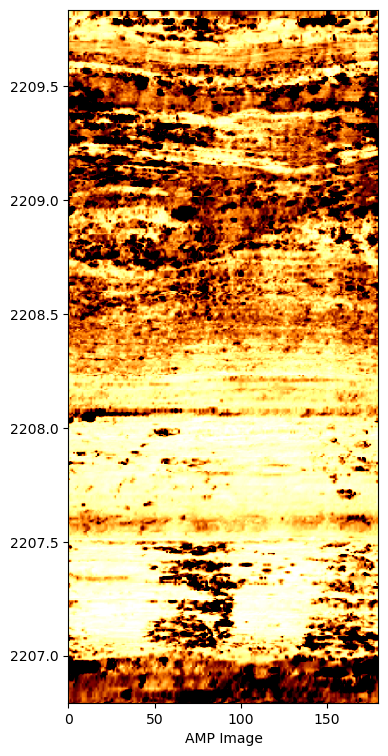

In [7]:
Image_plot(slice_img_df)

## Plot AMP (dB) Histogram according to range values

Plot histogram and segment image according the definitions present in [Menezes de Jesus et al, 2016](https://onepetro.org/petrophysics/article/57/06/620/171448/Permeability-Estimation-Using-Ultrasonic-Borehole).

In [8]:
# Flatten amplitude values
data = img_data.values.flatten('F')

In [10]:
# User definded thresholds
threshold = [22, 28, 32]

# User definded range
range_dB = np.array((-20, 40))

# User definded number of bins in histogram
n_bins = 50

# range for every bin
delta_bin = np.abs((range_dB[1] - range_dB[0]))/n_bins

# Compute the number of bins per class based on 'delta_bin'
range_bins = np.array((int((threshold[0] - range_dB[0])//delta_bin),
                       int((threshold[1] - range_dB[0])//delta_bin),
                       int((threshold[2] - range_dB[0])//delta_bin)))

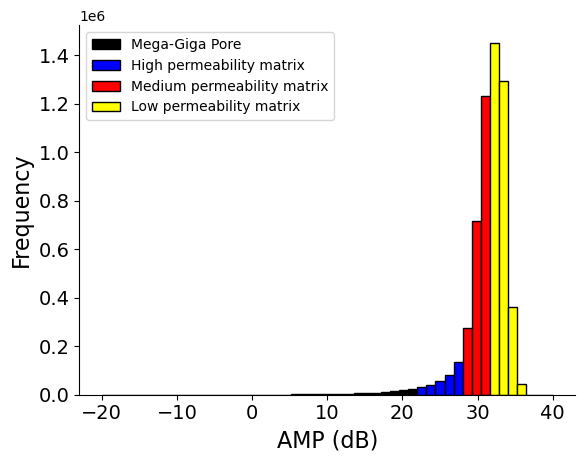

In [11]:
from matplotlib.patches import Rectangle

N, bins, patches = plt.hist(data, bins=n_bins, ec="k", range=(range_dB[0], range_dB[1]))

mgp = (0.0, 0.0, 0.0, 1.0)    # for Mega-Giga Pore values
hpm = (0.0, 0.0, 1.0, 1.0)    # for High-Permeability matrix values
mpm = (1.0, 0.0, 0.0, 1.0)    # for Medium-Permeability matrix values
lpm = (1.0, 1.0, 0.0, 1.0)    # for Low-Permeability matrix values


for i in range(0,range_bins[0]):
    patches[i].set_facecolor(mgp)
    
for i in range(range_bins[0],range_bins[1]):
    patches[i].set_facecolor(hpm)
    
for i in range(range_bins[1],range_bins[2]):
    patches[i].set_facecolor(mpm)
    
for i in range(range_bins[2],n_bins):
    patches[i].set_facecolor(lpm)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [mgp, hpm, mpm, lpm]]
labels= ['Mega-Giga Pore', 'High permeability matrix', 'Medium permeability matrix', 'Low permeability matrix']
plt.legend(handles, labels)

plt.xlabel('AMP (dB)', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.show()

## Segment after histogram categories

In [12]:
amp_array = img_data.values
amp_segment = np.zeros(amp_array.shape)

for i, img_row in enumerate(amp_array):
    for j, amp_value in enumerate(img_row):
        
        if amp_value <= threshold[0]:
            amp_segment[i][j] = 3
        elif amp_value <= threshold[1]:
            amp_segment[i][j] = 2
        elif amp_value <= threshold[2]:
            amp_segment[i][j] = 1
        else:
            amp_segment[i][j] = 0

In [13]:
seg_df = pd.DataFrame(amp_segment)

seg_df.insert(0, column = 'DEPTH', value = img_data.index)
seg_df.set_index('DEPTH', inplace=True)

In [14]:
seg_df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
DEPTH,,,,,,,,,,,,,,,,,,,,,
2203.74524,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2203.75032,1.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2203.75540,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2203.76048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2203.76556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368.25596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2368.26104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2368.26612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Creat custom colormaps to plot segmentations
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['yellow', 'red', 'blue', 'black'])
custom_cmap_r = ListedColormap(['black', 'blue', 'red', 'yellow'])

In [16]:
slice_seg_df = seg_df.iloc[600:1200]

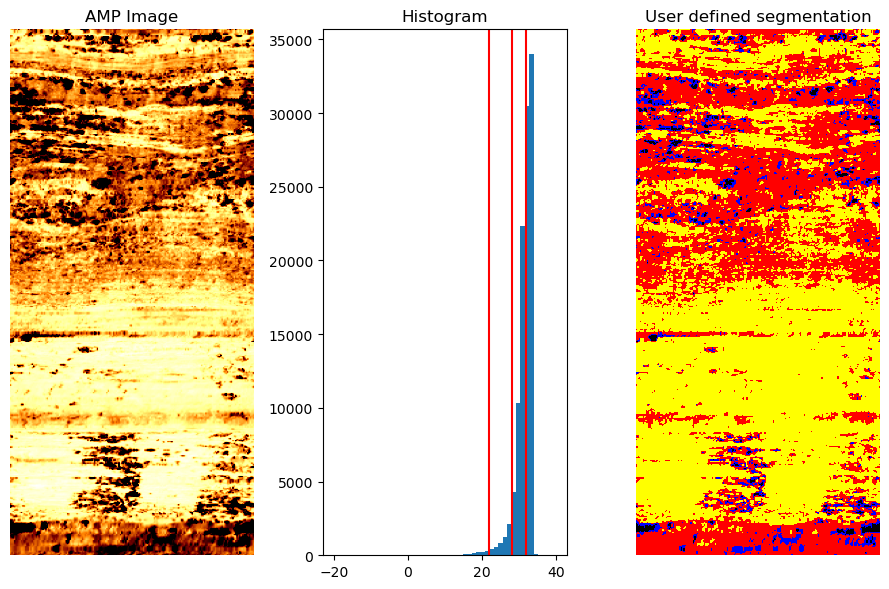

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,6), dpi=100)

# Plotting the original seg_df.
ax[0].imshow(slice_img_df, cmap='afmhot',aspect='auto',vmin= np.mean(img_data.values) - np.std(img_data.values),
              vmax= np.mean(img_data.values) + np.std(img_data.values))
ax[0].set_title('AMP Image')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(slice_img_df.values.flatten('F'), bins = bins)
ax[1].set_title('Histogram')
for thresh in threshold:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(slice_seg_df, cmap=custom_cmap, aspect='auto')
ax[2].set_title('User defined segmentation')
ax[2].axis('off')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

## Otsu (multi) thresholding

Otsu's method [1](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html#sphx-glr-auto-examples-segmentation-plot-multiotsu-py) allows to automatically determining the thresholds after an image's predetermined number of classes according to its pixel's intensity levels.

In [18]:
from skimage.filters import threshold_otsu, threshold_multiotsu

In [19]:
image = slice_img_df.values

In [20]:
otsu_thresholds = threshold_multiotsu(img_data.values, classes=4)
#binary_otsu = ndvi > thresh

print(otsu_thresholds)

[19.54620192 27.37461338 31.28881912]


In [21]:
# Using the threshold values for the 4 classes
regions = np.digitize(image, bins=otsu_thresholds)

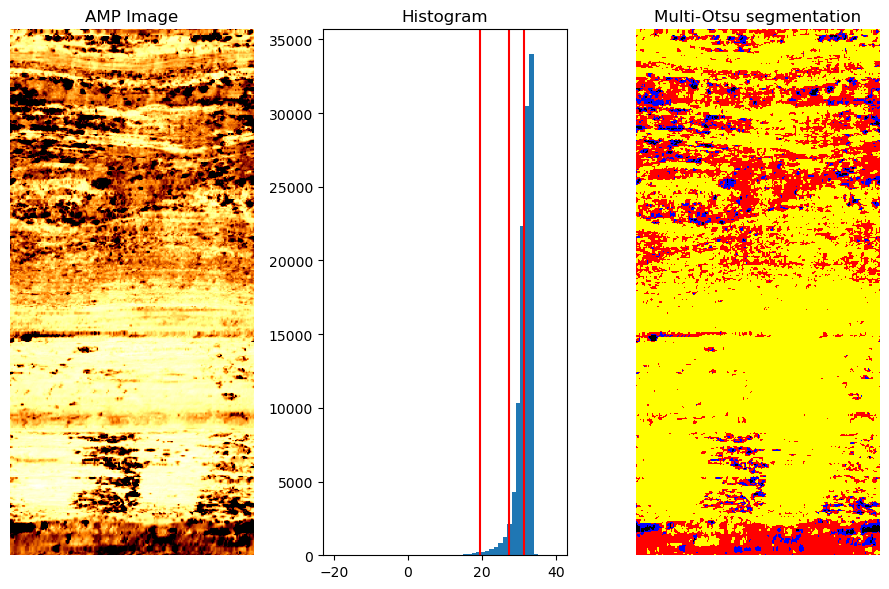

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,6), dpi=100)

# Plotting the original seg_df.
ax[0].imshow(image, cmap='afmhot',aspect='auto',vmin= np.mean(img_data.values) - np.std(img_data.values),
              vmax= np.mean(img_data.values) + np.std(img_data.values))
ax[0].set_title('AMP Image')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.flatten('F'), bins = bins)
ax[1].set_title('Histogram')
for thresh in otsu_thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap=custom_cmap_r, aspect='auto')
ax[2].set_title('Multi-Otsu segmentation')
ax[2].axis('off')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [23]:
# Compute the number of bins per class based on 'delta_bin'
otsu_range_bins = np.array((int((otsu_thresholds[0] - range_dB[0])//delta_bin),
                            int((otsu_thresholds[1] - range_dB[0])//delta_bin),
                            int((otsu_thresholds[2] - range_dB[0])//delta_bin)))

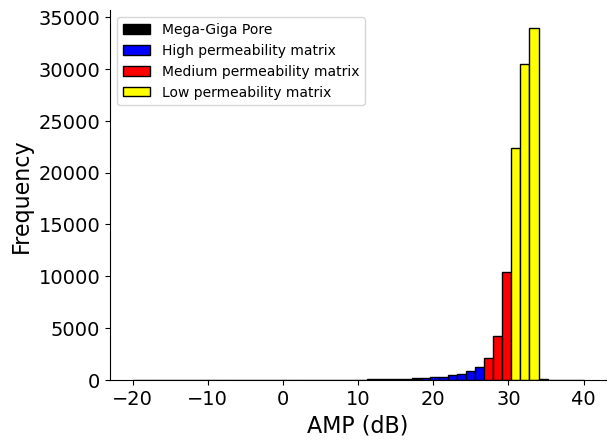

In [24]:
data = image.flatten('F')
N, bins, patches = plt.hist(data, bins = n_bins, ec="k", range = (range_dB[0], range_dB[1]))

mgp = (0.0, 0.0, 0.0, 1.0)
hpm = (0.0, 0.0, 1.0, 1.0)
mpm = (1.0, 0.0, 0.0, 1.0)
lpm = (1.0, 1.0, 0.0, 1.0)


for i in range(0,otsu_range_bins[0]):
    patches[i].set_facecolor(mgp)
    
for i in range(otsu_range_bins[0],otsu_range_bins[1]):
    patches[i].set_facecolor(hpm)
    
for i in range(otsu_range_bins[1],otsu_range_bins[2]):
    patches[i].set_facecolor(mpm)
    
for i in range(otsu_range_bins[2],n_bins):
    patches[i].set_facecolor(lpm)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [mgp, hpm, mpm, lpm]]
labels= ['Mega-Giga Pore', 'High permeability matrix', 'Medium permeability matrix', 'Low permeability matrix']
plt.legend(handles, labels)

plt.xlabel('AMP (dB)', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.show()